# Face Edge Detection

### 1. Importing libraries

In [1]:
import cv2
import numpy as np
import imutils
from imutils import face_utils
import dlib
import math
import matplotlib.pyplot as plt
import pandas as pd
import sys

### 2. Edge Detection
Defining a function which applies Robinson Edge filter on an image using cv2 filter2D method.

In [2]:
def edge_detection(image):
    kernel = np.array((
    [-2, -2, 0],
    [-2, 0, 2],
    [0, 2, 2]), dtype="int")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.filter2D(image, -1, kernel) 
    return image

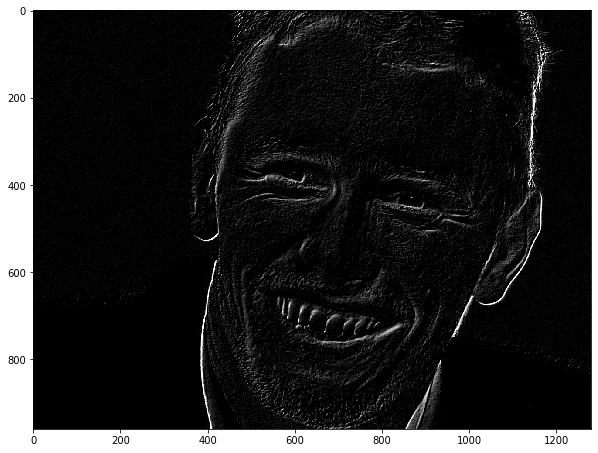

In [3]:
image = cv2.imread('face.jpg')
edge = edge_detection(image)
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(edge, cv2.COLOR_BGR2RGB))

### 3. Extracting Face Features

In [4]:
# Loading dlib face detector
detector = dlib.get_frontal_face_detector()
# Loding dlib face landmarks predictor
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [5]:
# Defining a function that will do the face detections and return a numpy array containing coordinates of 68 face landmarks.  
def detect(image):
    rects = detector(image, 1)
    if len(rects) < 1:
        return 'nan'
    else:
        for (i, rect) in enumerate(rects):
            shape = predictor(image, rect)
            shape = face_utils.shape_to_np(shape)
        return shape

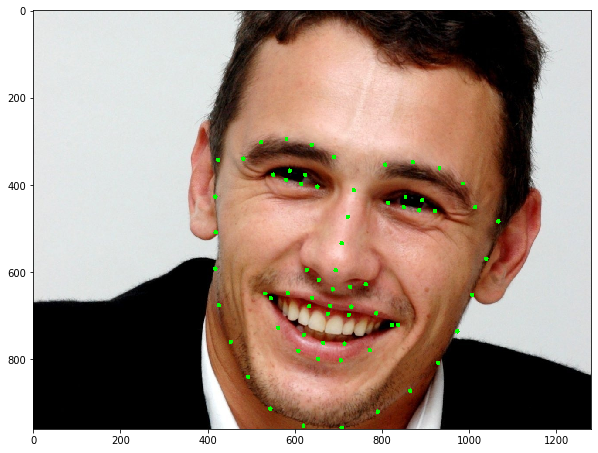

In [6]:
# Plot the land marks on image
lm = detect(image)
clone = image.copy()
for (x, y) in lm:
    cv2.circle(clone, (x, y), 5, (0, 255, 0), -1)
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))

In [7]:
# Define a Dictionary FACIAL_LANDMARKS_IDXS containg the points bounding different face parts
from collections import OrderedDict
FACIAL_LANDMARKS_IDXS = OrderedDict([
    ("mouth", (48, 68)),
    ("right_eyebrow", (17, 22)),
    ("left_eyebrow", (22, 27)),
    ("right_eye", (36, 42)),
    ("left_eye", (42, 48)),
    ("nose", (27, 35)),
    ("jaw", (0, 17))
])

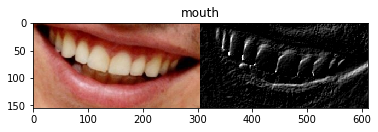

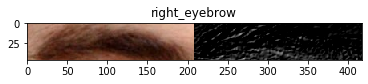

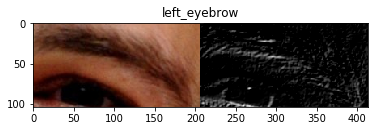

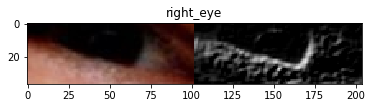

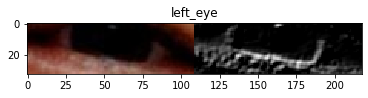

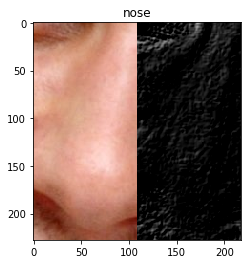

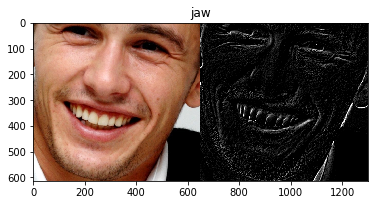

In [8]:
# loop over the face parts individually and extract different Features
for (name, (i, j)) in FACIAL_LANDMARKS_IDXS.items():
    clone = image.copy()
    [x, y, w, h] = cv2.boundingRect(np.array([lm[i:j]]))
    roi = image[y:y+h, x:x+w]
    roi_edge = edge[y:y+h, x:x+w]
    roi_edge = cv2.cvtColor(roi_edge, cv2.COLOR_BGR2RGB)
    viz = np.concatenate((roi, roi_edge), axis=1)
    plt.figure()
    plt.title(name)
    plt.imshow(cv2.cvtColor(viz, cv2.COLOR_BGR2RGB))

### 4. Expression Estimation
For this first extract landmarks from all the images, then vectorize the landmarks. Then train a SVM classifier using these landmarks and image labels.

In [9]:
# Function that will vectorize the landmarks. 
def getLandmark(shape):
    if shape == 'nan':
        return 'nan'
    else:
        xlist = shape[:,0]
        ylist = shape[:,1]
        xmean = np.mean(xlist) #Find both coordinates of centre of gravity
        ymean = np.mean(ylist)

        xcentral = [(x-xmean) for x in xlist] #Calculate distance between centre and other points in both axes
        ycentral = [(y-ymean) for y in ylist]

        landmarks_vectorised = []
        for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
            landmarks_vectorised.append(w)
            landmarks_vectorised.append(z)
            meannp = np.asarray((ymean,xmean))
            coornp = np.asarray((z,w))
            dist = np.linalg.norm(coornp-meannp)
            landmarks_vectorised.append(dist)
            landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))
        return landmarks_vectorised

There are 3000 images in the image directory.<br>
data.csv contains name of the image file and face expressions.<br>
Itrate over each image and extract landmarks.

In [10]:
data = pd.read_csv('data.csv')
landmarks_vectorised = []
i = 0
for im in data['image']:
    im = cv2.imread('image/' + im)
    shape = detect(im)
    lv = getLandmark(shape)
    landmarks_vectorised.append(lv)
    i = i+1
    sys.stdout.write("\r%d/%d"  %(i,data['image'].shape[0]))
    sys.stdout.flush()

2/3000

c:\users\arpit\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


3000/3000

In [11]:
# Encode the labels.
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
data['landmarks'] = landmarks_vectorised
data = data[data.landmarks != 'nan']
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(data['emotion'])
labels = label_encoder.classes_
print(labels)

['anger' 'disgust' 'happiness' 'neutral' 'sadness' 'surprise']


In [12]:
# Splitting Train and Test Set
from sklearn.model_selection import train_test_split
y =  integer_encoded
X = data['landmarks']
X = np.vstack(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [13]:
# Scaling the inputs to increase accuracy
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [14]:
# Training SVM Classifier
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train , y_train)

# Prediction of Test dataset
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
print(cm)

[[ 21   0   2  11   0   5]
 [  0   9   0   1   5   0]
 [  8   2 174  14   1   4]
 [  8   0  25 159   4   6]
 [  1   2   4  13   8   1]
 [  7   1   3  14   1  27]]


In [15]:
# Calculating accuracy
sum_first_diagonal = sum(cm[i][i] for i in range(cm.shape[0]))
accuracy = sum_first_diagonal / cm.sum()
print('Accuracy:', accuracy)

Accuracy: 0.7356746765249538


c:\users\arpit\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


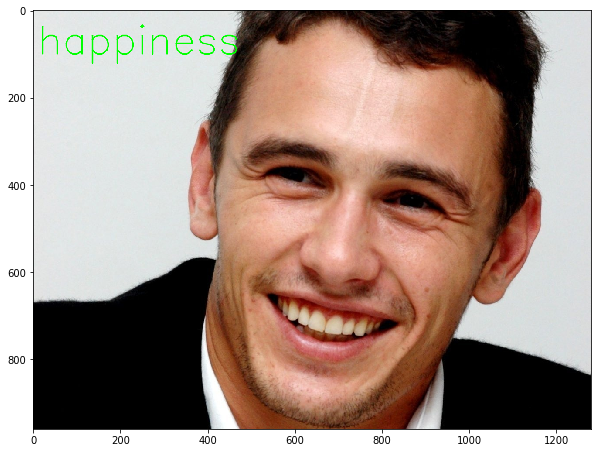

In [16]:
# Predicting Expression
landmarks = detect(image)
vec_landmarks = getLandmark(landmarks)
vec_landmarks = np.array(vec_landmarks).reshape([1,-1])
vec_landmarks = sc_X.transform(vec_landmarks)
p = classifier.predict(vec_landmarks)
exp = labels[p]
plt.figure(figsize=(10,10))
cv2.putText(image, exp[0], (10,100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 2, cv2.LINE_AA)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))